In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Download resources NLTK
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Inisialisasi
stop_words = set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data = pd.read_csv('/content/tiktok_google_play_reviews.csv', quoting=3, on_bad_lines='skip')

# Hanya ambil kolom yang diperlukan
data = data[['content', 'score']]


In [ ]:
data.head()

,content,score
0,No words,5
1,Great fun app so far!,5
2,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,5
3,Pictures and record,5
4,I love this amazing app,5


###Preprocessing

In [ ]:
# Cek missing values dan duplikat
print("Missing values:\n", data.isnull().sum())
print("\nDuplicate entries:", data.duplicated().sum())

Missing values:
 content    155
score      204
dtype: int64

Duplicate entries: 166761


In [ ]:
# Drop missing dan duplikat
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)


In [ ]:
# Konversi score jadi numerik
data['score'] = pd.to_numeric(data['score'], errors='coerce')

# Drop yang bukan angka
data = data.dropna(subset=['score'])

# Ubah jadi integer
data['score'] = data['score'].astype(int)

# Cek hasil
print(data['score'].unique())

[ 5  1  4  3  2  0 10 23]


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

data['cleaned'] = data['content'].apply(clean_text)

###Analisis Sentimen

In [ ]:
def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment'] = data['cleaned'].apply(get_sentiment)

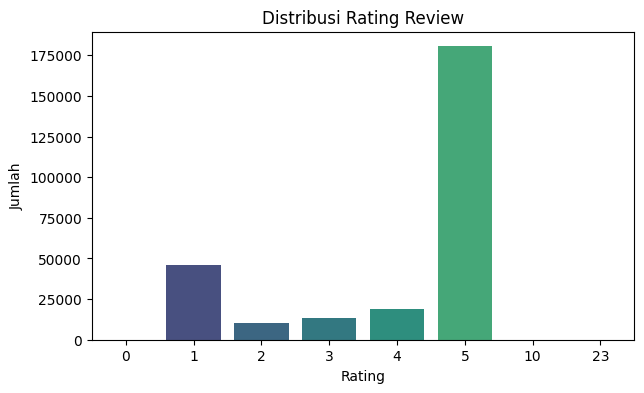

In [ ]:
plt.figure(figsize=(7, 4))
sns.countplot(x='score', data=data, palette='viridis')
plt.title('Distribusi Rating Review')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

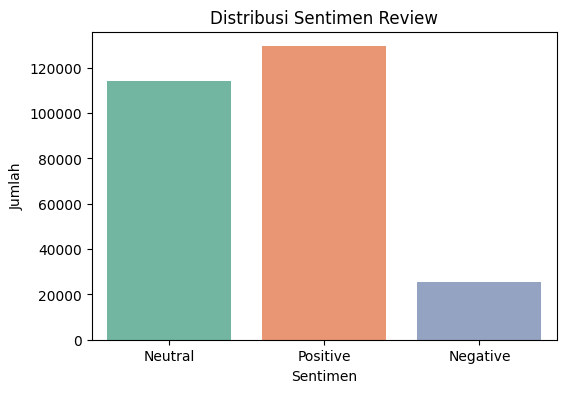

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=data, palette='Set2')
plt.title('Distribusi Sentimen Review')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

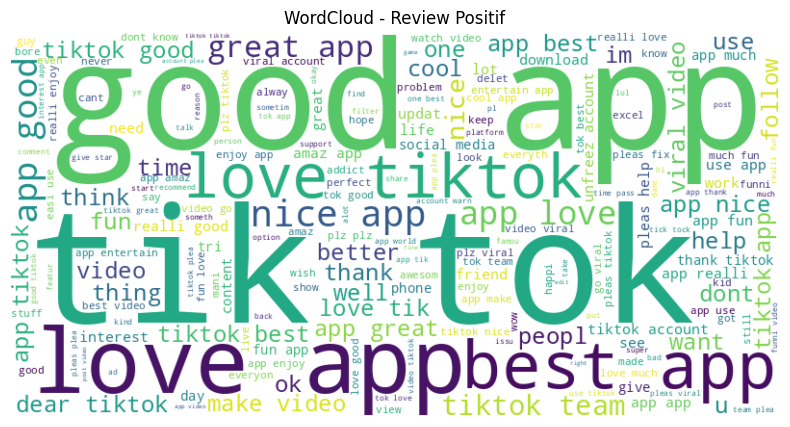

In [ ]:
# Wordcloud untuk review positif
positive_words = " ".join(data[data['sentiment'] == 'Positive']['cleaned'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Review Positif')
plt.show()

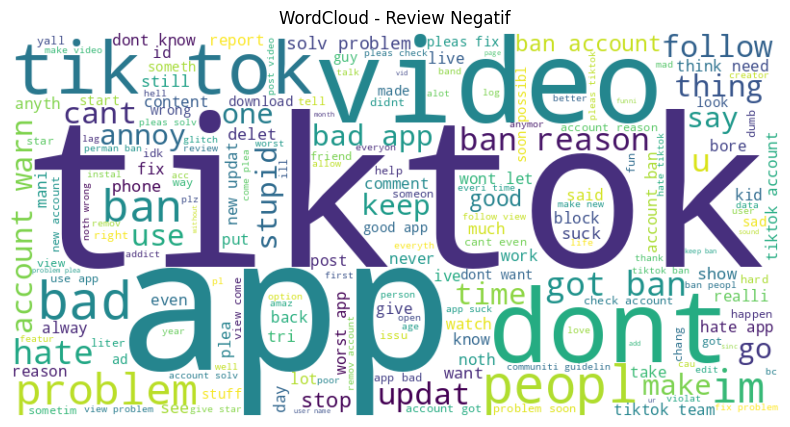

In [ ]:
negative_words = " ".join(data[data['sentiment'] == 'Negative']['cleaned'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Review Negatif')
plt.show()

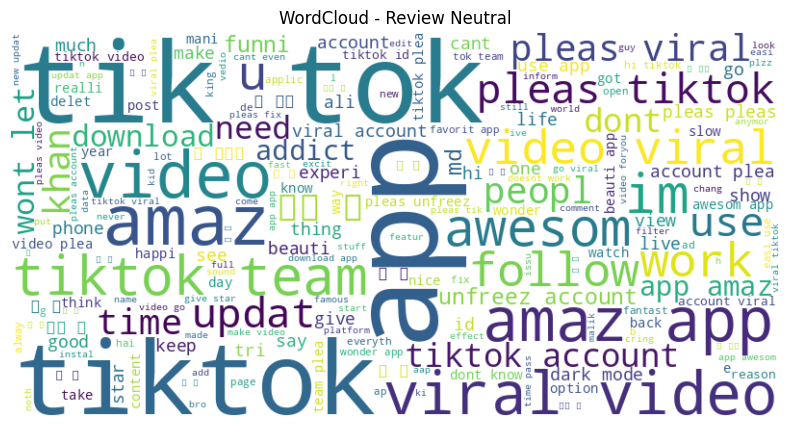

In [ ]:
neutral_words = " ".join(data[data['sentiment'] == 'Neutral']['cleaned'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(neutral_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Review Neutral')
plt.show()

###Model Classification

In [ ]:
# Membagi data
X = data['cleaned']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Model Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Prediksi dan Evaluasi
y_pred = model.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAkurasi:", accuracy_score(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.82      0.86      5087
     Neutral       0.97      0.98      0.97     22783
    Positive       0.96      0.97      0.97     25933

    accuracy                           0.96     53803
   macro avg       0.94      0.92      0.93     53803
weighted avg       0.96      0.96      0.96     53803


Confusion Matrix:
[[ 4186   317   584]
 [   85 22230   468]
 [  396   364 25173]]

Akurasi: 0.9588498782595766


In [ ]:
X_tfidf_full = vectorizer.fit_transform(X)
model_cv = LogisticRegression(max_iter=1000)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_cv, X_tfidf_full, y, cv=kfold, scoring='accuracy')

print("\nCross-Validation Accuracy per Fold:", scores)
print("Mean Cross-Validation Accuracy:", scores.mean())


Cross-Validation Accuracy per Fold: [0.96013233 0.95753025 0.95803208 0.95817999 0.95816141]
Mean Cross-Validation Accuracy: 0.958407212762857


####Memprediksi review

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
model_final = LogisticRegression(max_iter=1000)
model_final.fit(X_tfidf_full, y_encoded)

cv = vectorizer  # for consistency with your example naming

In [ ]:
def preprocess_review(review):
    review_lower = review.lower()
    review_clean = re.sub(r'\d+', '', review_lower)
    review_clean = review_clean.translate(str.maketrans('', '', string.punctuation))
    review_clean = review_clean.strip()
    tokens = review_clean.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
review_baru = "Terrible experience, keeps crashing and full of bugs."

for review_baru in [review_baru]:
    review_baru_preprocessed = preprocess_review(review_baru)
    review_baru_vector = cv.transform([review_baru_preprocessed])
    sentiment_prediksi = model_final.predict(review_baru_vector)
    sentiment_label = le.inverse_transform(sentiment_prediksi)[0]

    print(f"\nReview: {review_baru}")
    print(f"Predicted Sentiment: {sentiment_label}")


Review: Terrible experience, keeps crashing and full of bugs.
Predicted Sentiment: Negative
